<a href="https://colab.research.google.com/github/caroref/final/blob/master/S1_1_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import random
import shutil

import tensorflow as tf
import tensorflow_hub as hub
print("TensorFlow version is ", tf.__version__)

from tensorflow import keras
from tensorflow.keras import layers

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

W0604 09:28:39.720344 140485924284288 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


TensorFlow version is  1.13.1


In [2]:
# Allow Colab to access drive
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

#linking Colab to use drive as if local
!mkdir -p drive
!google-drive-ocamlfuse drive


E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 130912 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.3-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
base_dir = 'drive/Colab/EV/Base/'
like = os.path.join(base_dir, 'Like')
dislike = os.path.join(base_dir, 'Dislike')

# subdirectories for train/test/valid splits
trn_dir = 'drive/Colab/EV/S1/Train/'
tst_dir = 'drive/Colab/EV/S1/Test/'

trn_like = os.path.join(trn_dir, 'Like')
tst_like = os.path.join(tst_dir, 'Like')

trn_disl = os.path.join(trn_dir, 'Dislike')
tst_disl = os.path.join(tst_dir, 'Dislike')

In [0]:
# keras library import  for Saving and loading model and weights
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import load_model

In [5]:
# load json and create model
json_file = open('drive/Colab Notebooks/smodel/s1.1_model_num.json', 'r')

loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("drive/Colab Notebooks/smodel/s1.1_model_num.h5")
print("Loaded model from drive")

loaded_model=load_model('drive/Colab Notebooks/smodel/s1.1_model_num.hdf5')


Instructions for updating:
Colocations handled automatically by placer.


W0604 09:29:48.680505 140485924284288 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py:435: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Loaded model from drive
Instructions for updating:
Use tf.cast instead.


W0604 09:30:29.191646 140485924284288 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


W0604 09:30:36.539854 140485924284288 saving.py:287] Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.


In [6]:
#model was not compiled when saved so need to compile?

loaded_model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

loaded_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 18, 18, 2048)      21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 21,770,401
Non-trainable params: 34,432
_________________________________________________________________


In [7]:
image_size = 640
batch_size = 1

test_datagen = keras.preprocessing.image.ImageDataGenerator(
                rescale=1./255)

test_generator = test_datagen.flow_from_directory(
                tst_dir,
                target_size=(image_size, image_size),
                batch_size= batch_size,
                class_mode='binary')

filenames = test_generator.filenames
nb_samples = len(filenames)


Found 100 images belonging to 2 classes.


In [8]:
# Test accuracy 71%
 _, accuracy = loaded_model.evaluate_generator(generator=test_generator)
 print('Accuracy on test set: {}%'.format(round(accuracy, 3)*100))

Accuracy on test set: 69.9999988079071%


In [0]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

In [0]:
test_steps=test_generator.n // batch_size
test_generator.reset()
predict = loaded_model.predict_generator(test_generator, steps = test_steps)
predicted_classes = np.where(predict>0.5, 1, 0)

In [0]:
import sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns

Confusion Matrix
[[28 22]
 [22 28]]


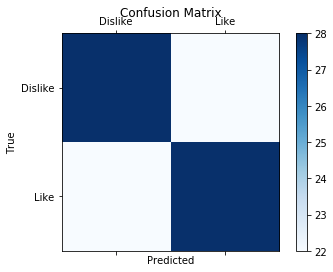

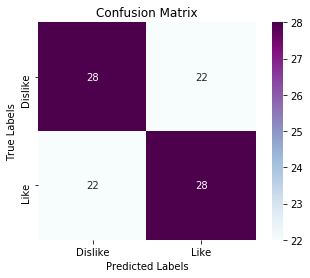

In [12]:
print('Confusion Matrix')
cm = sklearn.metrics.confusion_matrix(true_classes, predicted_classes)
print(cm)

#plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
fig.colorbar(cax)
ax.set_xticklabels([''] + class_labels)
ax.set_yticklabels([''] + class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#using seaborn
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap="BuPu", square=True);

# labels, title and ticks
ax.set_xlabel('Predicted Labels');
ax.set_ylabel('True Labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(class_labels + class_labels); 
ax.yaxis.set_ticklabels(class_labels + class_labels);


In [13]:
print('Classification Report') 
print(sklearn.metrics.classification_report(true_classes, predicted_classes, target_names=class_labels))

Classification Report
              precision    recall  f1-score   support

     Dislike       0.56      0.56      0.56        50
        Like       0.56      0.56      0.56        50

    accuracy                           0.56       100
   macro avg       0.56      0.56      0.56       100
weighted avg       0.56      0.56      0.56       100



In [0]:
#make both true_classes and predicted_classes into lists
t_classes = list(true_classes)

p_classes = []
for sublist in predicted_classes:
    for item in sublist:
        p_classes.append(item)

In [15]:
print(p_classes)
print(t_classes)
print(filenames)


combined = [p_classes, t_classes, filenames]
#might need to transpose

[1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
['Dislike/Dislike_1.jpg', 'Dislike/Dislike_10.jpg', 'Dislike/Dislike_11.jpg', 'Dislike/Dislike_12.jpg', 'Dislike/Dislike_13.jpg', 'Dislike/Dislike_14.jpg', 'Dislike/Dislike_15.jpg', 'Dislike/Dislike_16.jpg', 'Dislike/Dislike_17.jpg', 'Dislike/Dislike_18.jpg', 'Dislike/Dislike_19.jpg', 'Dislike/Dislike_2.jpg', 'Dislike/Dislike_20.jpg', 'Dislike/Dislike_21.jpg', 'Dislike/Dislike_22.jpg', 'Dislike/